# Timestamp를 이용한 시간별 기본 분석
## 정보보안기능 중 가용성 침해에 초점

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../dataset/track1.csv')
df.Timestamp = pd.to_datetime(df.Timestamp)

### Status 컬럼을 통한 이상치 발견 및 제거
- 200, 302, 404 등으로 표시돼야할 Status 컬럼에서 이상치 발견
- 노멀 스테이터스와 에러 스테이터스의 비율 (99.1% vs 0.9%)
- 스테이터스가 잘 못 인코딩된 로그 데이터를 제거하고 분석을 진행함

In [6]:
df['Status'].unique()

array(['200', '404', '302', '403', '"/var/www/html/wp-includes/"',
       '"/var/www/html/wp-includes/js/"',
       '"/var/www/html/wp-includes/js/jquery/"', '500', 'while',
       'stderr:', '"/var/www/html/wp-content/themes/oceanwp/assets/js/"',
       '"/var/www/html/wp-content/themes/oceanwp/assets/"',
       '"/var/www/html/wp-content/themes/oceanwp/assets/js/third/"',
       '499', 'be', '301', '"/var/www/html/wp-includes/blocks/"',
       '"/var/www/html/wp-includes/certificates/"',
       '"/var/www/html/wp-includes/css/"',
       '"/var/www/html/wp-includes/images/"', 'constant', 'open',
       'opening', 'for', 'Permission', nan, 'with', '400', '206', '405',
       '\\xEA\\xB1\\xB4\\xEC\\xB6\\x95\\xEB\\xB9\\x84\\xEA\\xB0\\x80',
       '\\xEC\\x95\\x84\\xEB\\x8B\\x88\\xEA\\xB3\\xA0,',
       '\\xEB\\x8C\\x80\\xED\\x95\\x9C',
       '\\xEC\\x8B\\xA0\\xEA\\xB7\\x9C\\xEB\\xB6\\x84\\xEC\\x96\\x91\\xEC\\x8B\\x9C\\xEC\\x9E\\xA5\\xEC\\x97\\x90\\xEC\\x84\\x9C\\xEC\\x9D\\x98',
       '

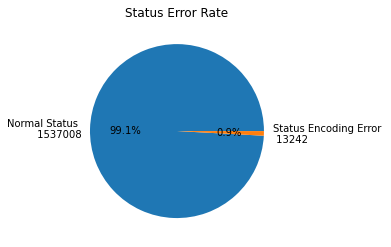

In [8]:
a = df[df['Status'].astype(str).str.isnumeric()] # 정상적인 Status 데이터
b = df[~df['Status'].astype(str).str.isnumeric()] # Status Encoding Error 데이터
ratio = [len(a), len(b)]
labels = [f'Normal Status \n {len(a)}', f'Status Encoding Error \n {len(b)}']
plt.title('Status Error Rate')
plt.pie(ratio, labels=labels, autopct='%.1f%%')
plt.show()

In [9]:
df = df[df['Status'].astype(str).str.isnumeric()]
df.Status.unique()

array(['200', '404', '302', '403', '500', '499', '301', '400', '206',
       '405', '304'], dtype=object)

## Timestamp 컬럼을 Day, Hour, Minute, Second로 나눕니다.

In [10]:
df['Day'] = df['Timestamp'].dt.day
df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute
df['Second'] = df['Timestamp'].dt.second

In [11]:
df.head()

,Timestamp,Method,Protocol,Status,Referer,Path,Host,UA,Payload,Bytes,Day,Hour,Minute,Second
0,2020-08-24 10:00:18,GET,HTTP/1.1,200,"""-""",/1000/wp-includes/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6226.0,24,10,0,18
1,2020-08-24 10:00:18,GET,HTTP/1.1,200,"""-""",/1000/wp-login/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6226.0,24,10,0,18
2,2020-08-24 10:00:18,GET,HTTP/1.1,200,"""-""",/1000/wp-register/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6232.0,24,10,0,18
3,2020-08-24 10:00:18,GET,HTTP/1.1,200,"""-""",/1000/wp/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6248.0,24,10,0,18
4,2020-08-24 10:00:19,GET,HTTP/1.1,200,"""-""",/1000/wp-content/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6224.0,24,10,0,19


### 총 5일간에 로그 기록이 존재 (24, 25, 26, 27, 28)
- 기록된 로그는 24일이 36938건으로 가장 적고 27일이 471092건으로 가장 많습니다.

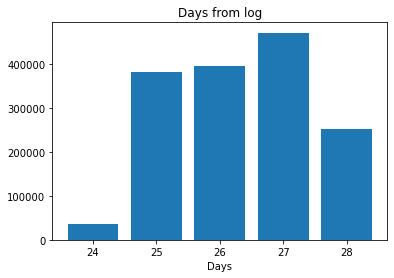

27    471092
26    396362
25    381511
28    251105
24     36938
Name: Day, dtype: int64


In [12]:
x = df['Day'].value_counts().index
y = df['Day'].value_counts()
plt.title('Days from log')
plt.xlabel('Days')
plt.bar(x, y)
plt.show()
print(y)

### 일별 시간(Hours) 로그 분포
- 24일 : 0 ~ 9시 접근기록이 없습니다.
- 25일, 26일, 27일 : 1 ~ 9시 접근기록이 없습니다.
- 28일 : 0 ~ 9시, 20 ~ 24시 접근기록이 없습니다.
- 접근기록이 있는 데이터 중 
    - 24일 20시가 1089건으로 가장 적은 접근이 있었습니다.
    - 27일 14시가 99674건으로 가장 많은 접근이 시도되었습니다.
- 11 ~ 12 부터 14 ~ 15 까지 공격이 진행된 것으로 예상됩니다.

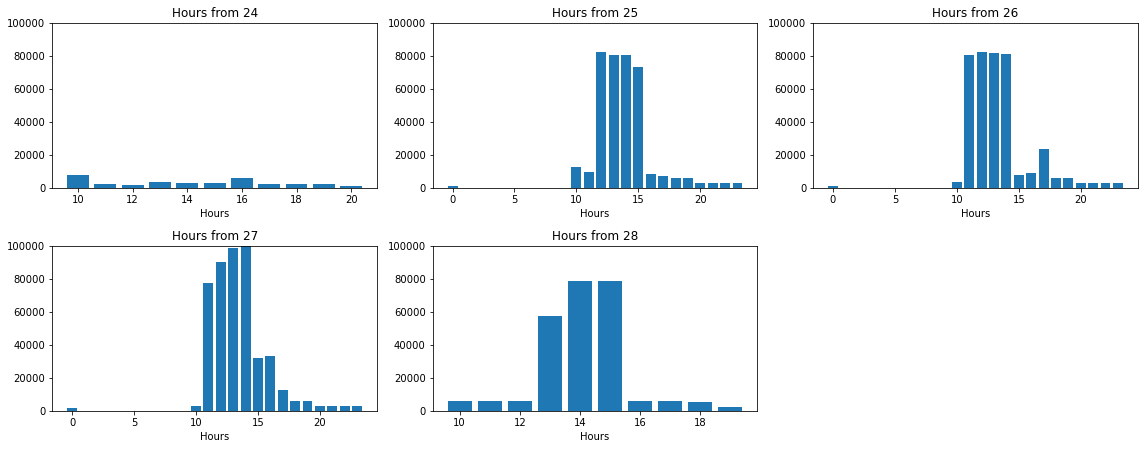

In [13]:
days = df['Day'].unique()
plt.figure(figsize=(16,9))
result = {}
for i in range(5):
    x = df[df['Day'] == days[i] ]['Hour'].value_counts().index
    y = df[df['Day'] == days[i] ]['Hour'].value_counts()
    result[days[i]] = y
    plt.subplot(3, 3, i+1)
    plt.title(f'Hours from {days[i]}')
    plt.xlabel('Hours')
    plt.ylim([0,100000])
    plt.tight_layout()
    plt.bar(x, y)
plt.show()

In [14]:
hour_min_max = {}
for i in result.keys():
    hour_min_max[i] = result[i].min(), result[i].max()

hour_min_max

{24: (1089, 7983),
 25: (1445, 82421),
 26: (1451, 82543),
 27: (1484, 99674),
 28: (2284, 78503)}

# 시나리오#1

### 웹 스크래핑, 크롤러
- 분단위 평균 기록횟수를 훌쩍 넘어가는 특정 시간대를 추출하여 리스팅
- 추출된 특정 시간대에서 사용된 UA 중 특수한 UA가 있는지 추출
- 추출된 특정 시간대에서 일반적인 접속량을 훌쩍 넘기는 Host 추출하여 리스팅
- 추출된 10개 Host의 패턴 분석 (Referer, Path, Bytes, 머무는 시간 등)
- 발견된 패턴대로 다른 Host에 대입하여 웹 스크래핑 입증

In [32]:
df = pd.read_csv('../dataset/track1.csv') # 데이터 프레임 초기화
df.Timestamp = pd.to_datetime(df.Timestamp) 
df = df[df['Status'].astype(str).str.isnumeric()] # 이상치 제거
df['Timestamp'] = df['Timestamp'].dt.strftime('%Y-%m-%d %H:%M') # 시계열 데이터를 1분 단위로 설정
df.head()

,Timestamp,Method,Protocol,Status,Referer,Path,Host,UA,Payload,Bytes
0,2020-08-24 10:00,GET,HTTP/1.1,200,"""-""",/1000/wp-includes/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6226.0
1,2020-08-24 10:00,GET,HTTP/1.1,200,"""-""",/1000/wp-login/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6226.0
2,2020-08-24 10:00,GET,HTTP/1.1,200,"""-""",/1000/wp-register/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6232.0
3,2020-08-24 10:00,GET,HTTP/1.1,200,"""-""",/1000/wp/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6248.0
4,2020-08-24 10:00,GET,HTTP/1.1,200,"""-""",/1000/wp-content/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6224.0


In [33]:
time_grp = df.groupby(['Timestamp'])
time_grp.count()

,Method,Protocol,Status,Referer,Path,Host,UA,Payload,Bytes
Timestamp,,,,,,,,,
2020-08-24 10:00,9,9,9,9,9,9,9,9,9
2020-08-24 10:01,11,11,11,11,11,11,11,11,11
2020-08-24 10:02,28,28,28,28,28,28,28,28,28
2020-08-24 10:03,38,38,38,38,38,38,38,38,38
2020-08-24 10:04,31,31,31,31,31,31,31,31,31
...,...,...,...,...,...,...,...,...,...
2020-08-28 19:42,48,48,48,48,48,48,48,48,48
2020-08-28 19:43,49,49,49,49,49,48,49,49,49
2020-08-28 19:44,54,54,54,54,54,54,54,54,54


In [6]:
times = {}
host = []
for name, group in time_grp.Host:
#     print(name + ' : ' + str(len(group)))
#     print()
    times[name] = int(len(group))

times = pd.DataFrame.from_dict(times, orient='index')
times.describe()

,0
count,3822.000000
mean,402.147567
std,736.033061
min,1.000000
25%,48.000000
50%,95.000000
75%,148.000000
max,3859.000000


<AxesSubplot:>

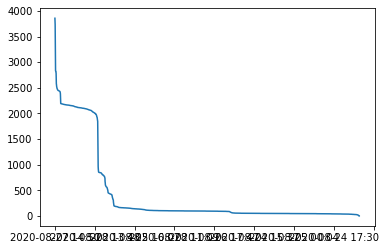

In [7]:
times[0].sort_values(ascending=False).plot()

In [31]:
x = times[0].sort_values(ascending=False).index
y = times[0].sort_values(ascending=False)

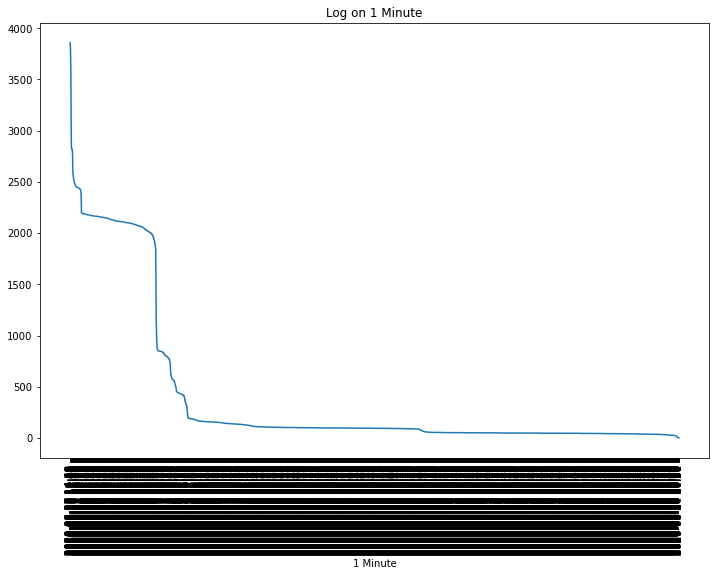

In [33]:
plt.figure(figsize=(12,8))
plt.title('Log on 1 Minute')
plt.plot(x, y)
plt.xlabel('1 Minute')
plt.xticks(rotation=90)
plt.show()

In [8]:
result = {}
time_a = []
time_b = []
time_c = []
host = []
for name, group in time_grp.Host:
    if len(group) > 3000:
        time_a.append(name)
    elif len(group) <= 3000 and len(group) > 1500 :
        time_b.append(name)
    else:
        time_c.append(name)

In [9]:
print(len(time_a))
print(len(time_b))
print(len(time_c))

7
532
3283


In [215]:
532/3822

0.1391941391941392

In [15]:
for i in time_a:
    x = df[df['Timestamp'] == i]['Host'].value_counts().head(10)
    y = len(df[df['Timestamp'] == i]['Host'].value_counts())
    if y > 200:
        print(i)
        print(x)
        print('개별 호스트 유니크 :',y)
        print()

2020-08-27 14:47
188.45.31.20       1560
129.236.75.8         43
73.52.126.133        43
118.52.128.24        42
183.209.224.212      41
238.60.95.5          41
132.134.0.43         39
35.146.170.79        38
34.121.125.108       38
178.245.100.17       37
Name: Host, dtype: int64
개별 호스트 유니크 : 247

2020-08-27 14:48
188.45.31.20       1764
120.207.123.148      46
155.101.146.48       46
84.83.171.161        43
42.88.127.114        43
167.145.154.40       42
132.134.0.43         42
41.121.130.0         40
85.180.217.131       40
3.168.105.10         39
Name: Host, dtype: int64
개별 호스트 유니크 : 244

2020-08-27 14:49
188.45.31.20       1789
242.162.51.166       46
248.208.120.149      44
178.245.100.17       42
132.134.0.43         41
134.149.35.190       40
223.199.240.6        40
235.160.25.129       40
129.236.75.8         40
232.143.134.156      39
Name: Host, dtype: int64
개별 호스트 유니크 : 239

2020-08-27 14:50
188.45.31.20      1794
62.66.235.25        46
84.83.171.161       44
73.52.126.133 

# 분당 개별 유니크 호스트 수와 분당 가장 기록을 많이 남긴 호스트

In [276]:
funcHostUnique = lambda x: len(x['Host'].unique())
funcHostUniqueFirstValue = lambda x: x['Host'].value_counts()[0]
hostUnique = time_grp.apply(funcHostUnique)
hostUniqueFirstValue = time_grp.apply(funcHostUniqueFirstValue)

In [277]:
hostUniqueByMinute = pd.concat([(time_grp['Host'].count().rename('Count')), 
                      hostUnique.rename('HostUnq'), hostUniqueFirstValue.rename('HostFirstValue')], axis=1)

In [150]:
hostUniqueByMinute['HostUnq'].describe()

count    3822.000000
mean       81.928048
std        77.702654
min         1.000000
25%        35.000000
50%        66.000000
75%        75.000000
max       295.000000
Name: HostUnq, dtype: float64

In [151]:
hostUniqueByMinute['HostFirstValue'].describe()

count    3822.000000
mean       47.258503
std       162.658980
min         1.000000
25%         3.000000
50%         4.000000
75%        44.000000
max      3437.000000
Name: HostFirstValue, dtype: float64

<AxesSubplot:xlabel='Timestamp'>

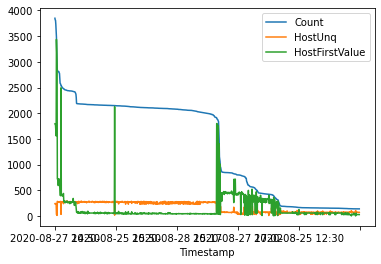

In [107]:
hostUniqueByMinute.sort_values(by='Count', ascending=False)[:1000].plot()

<AxesSubplot:xlabel='Timestamp'>

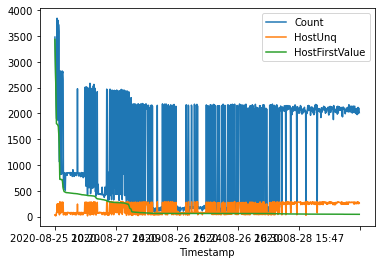

In [108]:
hostUniqueByMinute.sort_values(by='HostFirstValue', ascending=False)[:1000].plot()

<AxesSubplot:xlabel='Timestamp'>

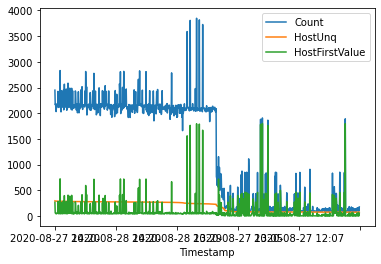

In [109]:
hostUniqueByMinute.sort_values(by='HostUnq', ascending=False)[:1000].plot()

In [131]:
hostUniqueByMinute[hostUniqueByMinute['HostFirstValue'] > 900]['HostUnq']

Timestamp
2020-08-27 14:47    248
2020-08-27 14:48    245
2020-08-27 14:50    241
2020-08-27 14:49    240
2020-08-27 14:51    238
2020-08-26 17:35     79
2020-08-26 17:37     79
2020-08-26 17:38     79
2020-08-26 17:36     75
2020-08-26 17:39     72
2020-08-25 10:21     38
2020-08-25 10:19     34
2020-08-25 10:20     33
2020-08-24 16:31     33
2020-08-24 10:42     19
2020-08-24 10:41     14
Name: HostUnq, dtype: int64

In [278]:
hostUniqueByMinute.index = pd.to_datetime(hostUniqueByMinute.index)

# 개별 호스트 유니크 수가 많은 인위적인 시간 패턴이 존재한다.

## 24일 패턴 없음

<AxesSubplot:xlabel='Timestamp'>

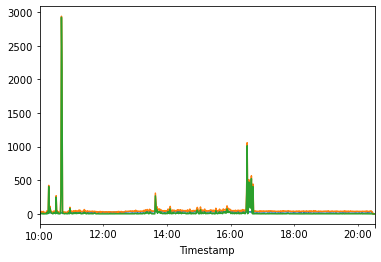

In [298]:
hostUniqueByMinute['2020-08-24 09:00':'2020-08-24 23:00']['HostUnq'].sort_index().plot()
hostUniqueByMinute['2020-08-24 09:00':'2020-08-24 23:00']['Count'].sort_index().plot()
hostUniqueByMinute['2020-08-24 09:00':'2020-08-24 23:00']['HostFirstValue'].sort_index().plot()

## 25일 총 8번 개별 호스트의 유니크 수가 급격히 늘어나는 패턴을 보임

<AxesSubplot:xlabel='Timestamp'>

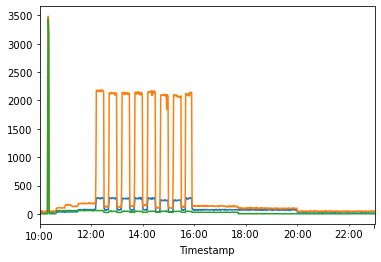

In [294]:
hostUniqueByMinute['2020-08-25 09:00':'2020-08-25 23:00']['HostUnq'].sort_index().plot()
hostUniqueByMinute['2020-08-25 09:00':'2020-08-25 23:00']['Count'].sort_index().plot()
hostUniqueByMinute['2020-08-25 09:00':'2020-08-25 23:00']['HostFirstValue'].sort_index().plot()

## 26일 총 8번 개별 호스트의 유니크 수가 급격히 늘어나는 패턴을 보임

<AxesSubplot:xlabel='Timestamp'>

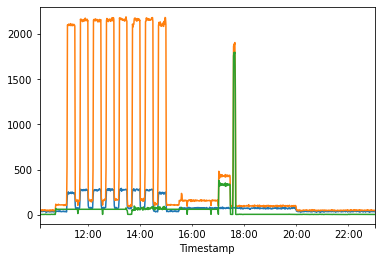

In [295]:
hostUniqueByMinute['2020-08-26 09:00':'2020-08-26 23:00']['HostUnq'].sort_index().plot()
hostUniqueByMinute['2020-08-26 09:00':'2020-08-26 23:00']['Count'].sort_index().plot()
hostUniqueByMinute['2020-08-26 09:00':'2020-08-26 23:00']['HostFirstValue'].sort_index().plot()

## 27일 총 8번 개별 호스트의 유니크 수가 급격히 늘어나는 패턴을 보임 (26일과 패턴이 똑같다)

<AxesSubplot:xlabel='Timestamp'>

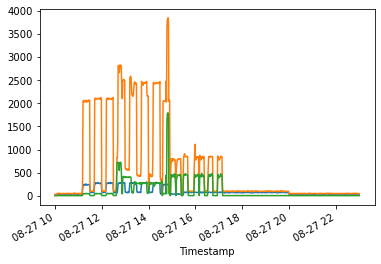

In [296]:
hostUniqueByMinute['2020-08-27 09:00':'2020-08-27 23:00']['HostUnq'].sort_index().plot()
hostUniqueByMinute['2020-08-27 09:00':'2020-08-27 23:00']['Count'].sort_index().plot()
hostUniqueByMinute['2020-08-27 09:00':'2020-08-27 23:00']['HostFirstValue'].sort_index().plot()

## 28일 총 6번 개별 호스트의 유니크 수가 급격히 늘어나는 패턴을 보임 (비슷한 패턴을 보인다)

<AxesSubplot:xlabel='Timestamp'>

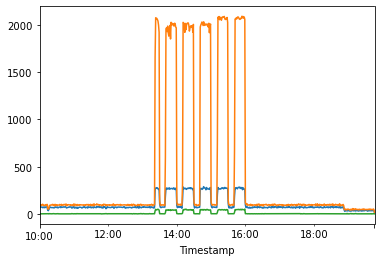

In [297]:
hostUniqueByMinute['2020-08-28 09:00':'2020-08-28 23:00']['HostUnq'].sort_index().plot()
hostUniqueByMinute['2020-08-28 09:00':'2020-08-28 23:00']['Count'].sort_index().plot()
hostUniqueByMinute['2020-08-28 09:00':'2020-08-28 23:00']['HostFirstValue'].sort_index().plot()

# 호스트가 단독으로 많이 들어오는 경우에는 시간에 따른 패턴이 없다.

<AxesSubplot:xlabel='Timestamp'>

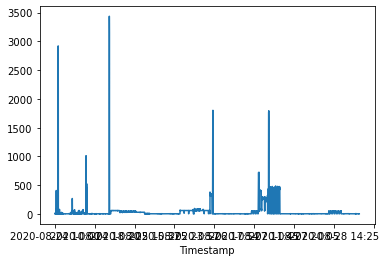

In [260]:
hostUniqueByMinute['HostFirstValue'].sort_index().plot()

In [132]:
df = df.set_index(df['Timestamp'])

In [138]:
anomalyTime_1 = df['2020-08-27 14:47' : '2020-08-27 14:51']

In [147]:
anomalyTime_1['Host'].value_counts()[1:60]

129.236.75.8       190
132.134.0.43       188
84.83.171.161      187
134.149.35.190     186
120.207.123.148    181
201.116.192.99     181
30.11.55.212       181
42.88.127.114      179
145.104.81.213     177
242.162.51.166     175
73.52.126.133      174
41.121.130.0       173
238.60.95.5        173
219.229.163.141    172
167.145.154.40     171
232.143.134.156    171
183.209.224.212    171
64.50.31.61        170
108.200.175.182    170
129.197.168.17     168
118.52.128.24      167
62.66.235.25       165
223.55.122.183     165
248.208.120.149    165
9.112.183.31       164
219.126.10.96      164
115.130.124.88     164
179.109.202.163    163
235.160.25.129     163
34.121.125.108     162
137.3.55.226       162
223.199.240.6      161
55.198.38.0        161
85.180.217.131     160
155.101.146.48     160
123.252.177.154    160
178.245.100.17     160
42.101.37.130      157
35.146.170.79      156
175.214.223.16     154
81.226.230.91      153
99.64.144.149      151
3.168.105.10       149
6.210.151.2

In [161]:
anomalyTime_1[anomalyTime_1['Host'] == '36.227.196.135']['Referer'].value_counts()

"http://wp.hotpost.kr/"                              106
"http://xe.coldshop.kr/shop?mid=shop&page=5"           6
"http://xe.coldshop.kr/shop?mid=shop&page=6"           4
"http://xe.coldshop.kr/shop?mid=shop&page=9"           4
"http://xe.coldshop.kr/shop?mid=shop&page=4"           3
"http://xe.coldshop.kr/shop?mid=shop&page=1"           2
"http://xe.coldshop.kr/shop?mid=shop&page=2"           2
"http://xe.coldshop.kr/shop?mid=shop&page=8"           2
"http://xe.coldshop.kr/shop?mid=shop&page=7"           2
"http://xe.coldshop.kr/shop?mid=shop&page=3"           1
"http://xe.coldshop.kr/notice?mid=notice&page=6"       1
"http://xe.coldshop.kr/notice?mid=notice&page=10"      1
"http://xe.coldshop.kr/notice?mid=notice&page=4"       1
Name: Referer, dtype: int64

In [177]:
anomalyTime_1[anomalyTime_1['Host'] == anomalyTime_1['Host'].value_counts().index[50]]['Referer'].value_counts()

"http://wp.hotpost.kr/"                              106
"http://xe.coldshop.kr/shop?mid=shop&page=5"           6
"http://xe.coldshop.kr/shop?mid=shop&page=6"           4
"http://xe.coldshop.kr/shop?mid=shop&page=9"           4
"http://xe.coldshop.kr/shop?mid=shop&page=4"           3
"http://xe.coldshop.kr/shop?mid=shop&page=1"           2
"http://xe.coldshop.kr/shop?mid=shop&page=2"           2
"http://xe.coldshop.kr/shop?mid=shop&page=8"           2
"http://xe.coldshop.kr/shop?mid=shop&page=7"           2
"http://xe.coldshop.kr/shop?mid=shop&page=3"           1
"http://xe.coldshop.kr/notice?mid=notice&page=6"       1
"http://xe.coldshop.kr/notice?mid=notice&page=10"      1
"http://xe.coldshop.kr/notice?mid=notice&page=4"       1
Name: Referer, dtype: int64

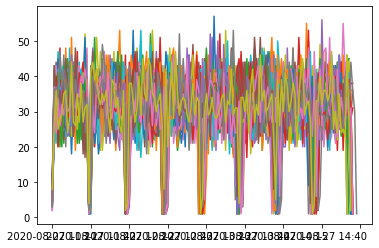

In [255]:
for i in range(1,50):
    df[df['Host'] == anomalyTime_1['Host'].value_counts().index[i]].index.value_counts().sort_index().plot()